# Segmentation with Random Forest

In [1]:
import numpy as np
import json
import cv2
import matplotlib.pyplot as plt
import matplotlib

import sampler
import node
import tree
import randomforest

%load_ext autoreload
%autoreload 2

In [2]:
cmap = matplotlib.colors.ListedColormap(["black", "red", "blue", "green"])

train_images = ["images/img_3.bmp",
                "images/img_5.bmp",
                "images/img_6.bmp",
                "images/img_11.bmp"]

train_segmentations = ["images/img_3_segMap.bmp", 
                       "images/img_5_segMap.bmp", 
                       "images/img_6_segMap.bmp", 
                       "images/img_11_segMap.bmp"]

test_images = ["images/img_7.bmp",
                "images/img_9.bmp",
                "images/img_10.bmp",
                "images/img_12.bmp"]

test_segmentations = ["images/img_7_segMap.bmp", 
                       "images/img_9_segMap.bmp", 
                       "images/img_10_segMap.bmp", 
                       "images/img_12_segMap.bmp"]

img.shape: (213, 320, 3)


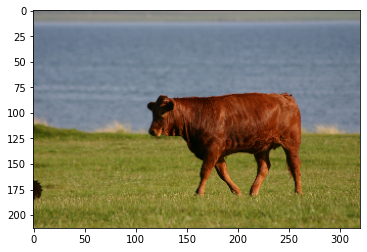

In [3]:
img = cv2.imread(cv2.samples.findFile(train_images[1]))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
print("img.shape:", img.shape)

segmap.shape: (213, 320)


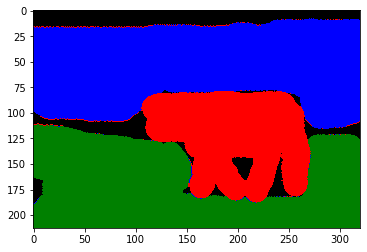

In [4]:
segmap = cv2.imread(cv2.samples.findFile(train_segmentations[1]))
segmap = cv2.cvtColor(segmap, cv2.COLOR_BGR2GRAY)
plt.imshow(segmap, cmap=cmap)
print("segmap.shape:", segmap.shape)

## Sample From Image

x:  297  y:  99
Example patch with label: 2


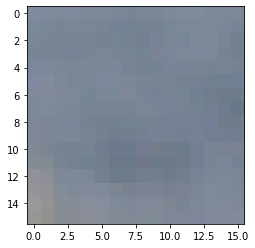

In [5]:
patch_size = 16

x = np.random.randint(0, img.shape[1]-patch_size)
y = np.random.randint(0, img.shape[0]-patch_size)
print("x: ", x, " y: ", y)
x_center = x + patch_size//2
y_center = y + patch_size//2 

patch = img[y:y+patch_size, x:x+patch_size, :]
label = segmap[y_center, x_center]

plt.imshow(patch)
print("Example patch with label:", label)

In [6]:
ps = sampler.PatchSampler(train_images, train_segmentations, [True, True, True, True], patch_size=16)
x_patches, y_patches = ps.extractpatches()

print("x_patches.shape:", x_patches.shape, "y_patches.shape:", y_patches.shape)
print("y_patches histogram:", np.bincount(y_patches))

x_patches.shape: (4000, 16, 16, 3) y_patches.shape: (4000,)
y_patches histogram: [1000 1000 1000 1000]


## Training

In [7]:
tree_params = {'depth': 15, 'pixel_locations':100, "random_color_values": 10, "no_of_thresholds": 50, "minimum_patches_at_leaf": 20, "classes": 4}
d = tree.DecisionTree(patches=x_patches, labels=y_patches , tree_param=tree_params)
d.train()
print("finished!")
trained_nodes = d.root_node # backup the trained tree

split-node: {'color': 2, 'pixel_location': [12, 12], 'th': 146} 0
split-node: {'color': 2, 'pixel_location': [15, 4], 'th': 215} 1
split-node: {'color': 0, 'pixel_location': [3, 8], 'th': 33} 2
split-node: {'color': 0, 'pixel_location': [11, 11], 'th': 96} 3
leaf-node: [0.04761905 0.95238095 0.         0.        ]
leaf-node: [0.39285714 0.5        0.         0.10714286]
split-node: {'color': 2, 'pixel_location': [0, 8], 'th': 45} 3
split-node: {'color': 0, 'pixel_location': [12, 9], 'th': 153} 4
split-node: {'color': 0, 'pixel_location': [3, 3], 'th': 51} 5
split-node: {'color': 0, 'pixel_location': [8, 5], 'th': 94} 6
leaf-node: [0.09090909 0.90909091 0.         0.        ]
leaf-node: [0.55 0.35 0.   0.1 ]
split-node: {'color': 1, 'pixel_location': [13, 9], 'th': 118} 6
split-node: {'color': 0, 'pixel_location': [15, 7], 'th': 58} 7
split-node: {'color': 0, 'pixel_location': [9, 11], 'th': 79} 8
split-node: {'color': 0, 'pixel_location': [3, 12], 'th': 64} 9
leaf-node: [0. 1. 0. 0.]
l

split-node: {'color': 0, 'pixel_location': [5, 11], 'th': 112} 13
leaf-node: [0. 0. 1. 0.]
split-node: {'color': 1, 'pixel_location': [4, 14], 'th': 131} 14
leaf-node: [0. 0. 1. 0.]
leaf-node: [0.07692308 0.07692308 0.84615385 0.        ]
leaf-node: [0.29411765 0.05882353 0.64705882 0.        ]
split-node: {'color': 0, 'pixel_location': [13, 14], 'th': 134} 12
leaf-node: [0.23809524 0.         0.76190476 0.        ]
split-node: {'color': 2, 'pixel_location': [4, 2], 'th': 183} 13
leaf-node: [0.84 0.   0.16 0.  ]
leaf-node: [0.875 0.125 0.    0.   ]
leaf-node: [0.69230769 0.19230769 0.         0.11538462]
split-node: {'color': 0, 'pixel_location': [12, 2], 'th': 170} 7
split-node: {'color': 1, 'pixel_location': [12, 10], 'th': 135} 8
leaf-node: [0.48148148 0.40740741 0.03703704 0.07407407]
leaf-node: [0.42424242 0.33333333 0.         0.24242424]
split-node: {'color': 2, 'pixel_location': [15, 8], 'th': 115} 8
leaf-node: [0.40740741 0.40740741 0.         0.18518519]
leaf-node: [0.25 0.35

## Prediction

In [8]:
d = tree.DecisionTree(patches=x_patches, labels=y_patches , tree_param=tree_params)
d.root_node = trained_nodes # recover tree from the backup

def do_pred(img_path, segmap_path):
    test_img = cv2.imread(cv2.samples.findFile(img_path))
    test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
    true_labels = cv2.imread(cv2.samples.findFile(segmap_path))
    true_labels = cv2.cvtColor(true_labels, cv2.COLOR_BGR2GRAY)

    # Prediction:
    predicted_img, _ = d.predict(test_img)

    true_hist = np.bincount(true_labels.flatten().astype(int))
    print("True labels histogram:\nOthers (0) = {} \nSheep (1) = {} \nWater (2) = {} \nGrass (3) = {}".format(true_hist[0], true_hist[1], true_hist[2], true_hist[3]))

    pred_hist = np.bincount(predicted_img.flatten().astype(int))
    print("\nPredicted labels histogram:\nOthers (0) = {} \nSheep (1) = {} \nWater (2) = {} \nGrass (3) = {}".format(pred_hist[0], pred_hist[1], pred_hist[2], pred_hist[3]))


    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,8))
    ax1.imshow(true_labels, cmap=cmap)
    ax1.set_title("True label image")
    ax2.imshow(predicted_img, cmap=cmap)
    ax2.set_title("Predicted label image")
    fig.tight_layout()

True labels histogram:
Others (0) = 3898 
Sheep (1) = 24902 
Water (2) = 7170 
Grass (3) = 32190

Predicted labels histogram:
Others (0) = 34501 
Sheep (1) = 19404 
Water (2) = 3441 
Grass (3) = 10814


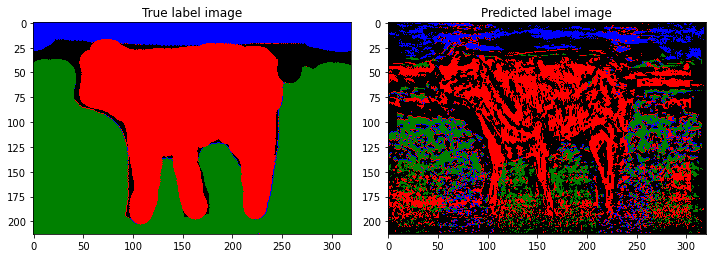

In [9]:
do_pred(test_images[0], test_segmentations[0])

True labels histogram:
Others (0) = 905 
Sheep (1) = 9173 
Water (2) = 0 
Grass (3) = 58082

Predicted labels histogram:
Others (0) = 39058 
Sheep (1) = 18518 
Water (2) = 378 
Grass (3) = 10206


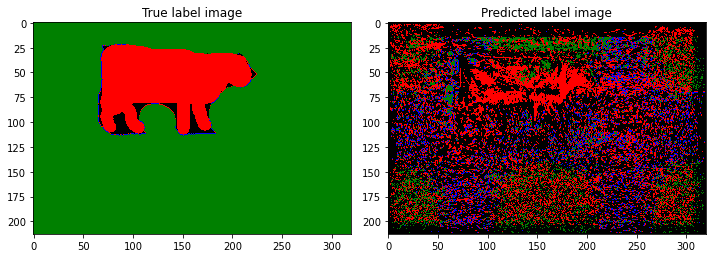

In [10]:
do_pred(test_images[1], test_segmentations[1])

True labels histogram:
Others (0) = 2024 
Sheep (1) = 13082 
Water (2) = 0 
Grass (3) = 53054

Predicted labels histogram:
Others (0) = 34237 
Sheep (1) = 21168 
Water (2) = 260 
Grass (3) = 12495


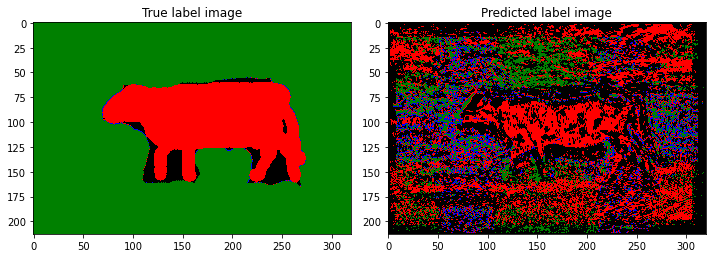

In [11]:
do_pred(test_images[2], test_segmentations[2])

True labels histogram:
Others (0) = 1215 
Sheep (1) = 19664 
Water (2) = 0 
Grass (3) = 47281

Predicted labels histogram:
Others (0) = 41225 
Sheep (1) = 13048 
Water (2) = 667 
Grass (3) = 13220


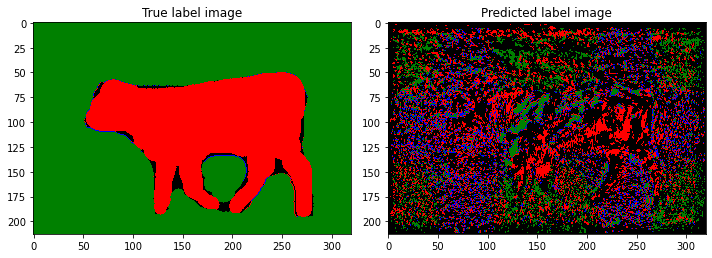

In [12]:
do_pred(test_images[3], test_segmentations[3])

**The potential reason behind not achieving excellent results may be:**

- Labeling is poor. There are many others labels in the segmentation images especially in the transitions.
- Different brightness levels of the images. For example `img_11.bmp` is too bright. But we don't have a bright image in the training set.
- There is water in the training data but very few water in the test images. This is using the model capacity for nothing.
- Make the dataset balanced including `Others` label causes output image to include too many `Others`. Because this label has many possible inputs.

## Random Forest

## Training

In [13]:
forest = randomforest.Forest(patches=x_patches, labels=y_patches , tree_param=tree_params, n_trees=5)
forest.create_forest()
print("finished!")

========== training tree-0 ==========
split-node: {'color': 1, 'pixel_location': [9, 3], 'th': 86} 0
split-node: {'color': 2, 'pixel_location': [2, 13], 'th': 66} 1
split-node: {'color': 2, 'pixel_location': [15, 1], 'th': 44} 2
split-node: {'color': 2, 'pixel_location': [10, 12], 'th': 53} 3
split-node: {'color': 0, 'pixel_location': [11, 4], 'th': 108} 4
split-node: {'color': 1, 'pixel_location': [8, 7], 'th': 72} 5
split-node: {'color': 2, 'pixel_location': [12, 11], 'th': 27} 6
split-node: {'color': 0, 'pixel_location': [0, 12], 'th': 83} 7
leaf-node: [0. 1. 0. 0.]
split-node: {'color': 2, 'pixel_location': [10, 5], 'th': 16} 8
leaf-node: [0. 1. 0. 0.]
leaf-node: [0.07407407 0.92592593 0.         0.        ]
leaf-node: [0. 1. 0. 0.]
leaf-node: [0.14814815 0.85185185 0.         0.        ]
leaf-node: [0. 1. 0. 0.]
leaf-node: [0. 1. 0. 0.]
split-node: {'color': 0, 'pixel_location': [11, 3], 'th': 119} 3
split-node: {'color': 0, 'pixel_location': [11, 3], 'th': 67} 4
leaf-node: [0.236

leaf-node: [0.60869565 0.13043478 0.         0.26086957]
split-node: {'color': 2, 'pixel_location': [9, 11], 'th': 166} 10
leaf-node: [0.39130435 0.         0.         0.60869565]
leaf-node: [0.17391304 0.         0.         0.82608696]
split-node: {'color': 2, 'pixel_location': [12, 15], 'th': 163} 9
split-node: {'color': 0, 'pixel_location': [3, 12], 'th': 240} 10
leaf-node: [0.2  0.04 0.   0.76]
leaf-node: [0.33333333 0.19047619 0.         0.47619048]
split-node: {'color': 2, 'pixel_location': [4, 1], 'th': 179} 10
split-node: {'color': 2, 'pixel_location': [4, 0], 'th': 165} 11
leaf-node: [0.18181818 0.         0.         0.81818182]
leaf-node: [0.0952381 0.        0.        0.9047619]
split-node: {'color': 2, 'pixel_location': [4, 13], 'th': 196} 11
split-node: {'color': 2, 'pixel_location': [5, 14], 'th': 182} 12
leaf-node: [0.1 0.  0.  0.9]
leaf-node: [0.17391304 0.04347826 0.         0.7826087 ]
leaf-node: [0.07142857 0.07142857 0.         0.85714286]
split-node: {'color': 2, '

split-node: {'color': 2, 'pixel_location': [8, 11], 'th': 140} 8
split-node: {'color': 2, 'pixel_location': [4, 13], 'th': 111} 9
split-node: {'color': 2, 'pixel_location': [0, 3], 'th': 66} 10
split-node: {'color': 1, 'pixel_location': [3, 7], 'th': 120} 11
leaf-node: [0.3        0.53333333 0.         0.16666667]
split-node: {'color': 2, 'pixel_location': [1, 6], 'th': 65} 12
leaf-node: [0.37931034 0.20689655 0.         0.4137931 ]
leaf-node: [0.21621622 0.08108108 0.         0.7027027 ]
split-node: {'color': 2, 'pixel_location': [4, 10], 'th': 74} 11
split-node: {'color': 0, 'pixel_location': [11, 15], 'th': 112} 12
leaf-node: [0.45 0.4  0.   0.15]
split-node: {'color': 0, 'pixel_location': [14, 1], 'th': 142} 13
leaf-node: [0.23684211 0.15789474 0.         0.60526316]
leaf-node: [0.38888889 0.27777778 0.         0.33333333]
split-node: {'color': 0, 'pixel_location': [13, 6], 'th': 125} 12
leaf-node: [0.30769231 0.07692308 0.         0.61538462]
split-node: {'color': 0, 'pixel_locati

split-node: {'color': 2, 'pixel_location': [13, 12], 'th': 197} 9
leaf-node: [0. 0. 0. 1.]
leaf-node: [0.   0.05 0.   0.95]
split-node: {'color': 2, 'pixel_location': [10, 2], 'th': 208} 8
leaf-node: [0.1 0.  0.  0.9]
leaf-node: [0.04166667 0.125      0.         0.83333333]
========== training tree-2 ==========
split-node: {'color': 0, 'pixel_location': [5, 12], 'th': 169} 0
split-node: {'color': 2, 'pixel_location': [8, 13], 'th': 104} 1
split-node: {'color': 2, 'pixel_location': [10, 3], 'th': 35} 2
split-node: {'color': 1, 'pixel_location': [1, 9], 'th': 120} 3
split-node: {'color': 1, 'pixel_location': [12, 9], 'th': 29} 4
leaf-node: [0. 1. 0. 0.]
split-node: {'color': 2, 'pixel_location': [7, 11], 'th': 37} 5
split-node: {'color': 1, 'pixel_location': [2, 10], 'th': 45} 6
leaf-node: [0. 1. 0. 0.]
split-node: {'color': 0, 'pixel_location': [14, 9], 'th': 66} 7
leaf-node: [0.04545455 0.95454545 0.         0.        ]
split-node: {'color': 0, 'pixel_location': [3, 12], 'th': 120} 8
s

split-node: {'color': 2, 'pixel_location': [14, 5], 'th': 146} 10
leaf-node: [0.52380952 0.         0.47619048 0.        ]
split-node: {'color': 2, 'pixel_location': [0, 10], 'th': 154} 11
split-node: {'color': 2, 'pixel_location': [3, 15], 'th': 153} 12
leaf-node: [0.         0.03030303 0.96969697 0.        ]
leaf-node: [0.05 0.   0.95 0.  ]
leaf-node: [0.22727273 0.         0.77272727 0.        ]
split-node: {'color': 1, 'pixel_location': [1, 9], 'th': 151} 8
split-node: {'color': 1, 'pixel_location': [7, 3], 'th': 145} 9
leaf-node: [0.38461538 0.         0.61538462 0.        ]
leaf-node: [0.41666667 0.04166667 0.5        0.04166667]
leaf-node: [0.90322581 0.06451613 0.03225806 0.        ]
split-node: {'color': 2, 'pixel_location': [6, 11], 'th': 143} 6
split-node: {'color': 1, 'pixel_location': [14, 8], 'th': 135} 7
leaf-node: [0.36363636 0.04545455 0.59090909 0.        ]
leaf-node: [0.76666667 0.03333333 0.16666667 0.03333333]
split-node: {'color': 2, 'pixel_location': [8, 7], 'th'

leaf-node: [0.33333333 0.52380952 0.         0.14285714]
split-node: {'color': 0, 'pixel_location': [6, 12], 'th': 118} 9
leaf-node: [0.34482759 0.10344828 0.         0.55172414]
split-node: {'color': 1, 'pixel_location': [9, 14], 'th': 125} 10
leaf-node: [0.15 0.1  0.   0.75]
leaf-node: [0.28571429 0.0952381  0.         0.61904762]
split-node: {'color': 2, 'pixel_location': [6, 3], 'th': 56} 7
split-node: {'color': 1, 'pixel_location': [3, 15], 'th': 121} 8
leaf-node: [0.52380952 0.33333333 0.         0.14285714]
leaf-node: [0.5 0.  0.  0.5]
split-node: {'color': 0, 'pixel_location': [14, 1], 'th': 131} 8
split-node: {'color': 2, 'pixel_location': [5, 9], 'th': 61} 9
leaf-node: [0.38095238 0.19047619 0.         0.42857143]
leaf-node: [0.36363636 0.         0.         0.63636364]
leaf-node: [0.24 0.12 0.   0.64]
split-node: {'color': 1, 'pixel_location': [11, 9], 'th': 127} 4
leaf-node: [0.45 0.55 0.   0.  ]
leaf-node: [0.44 0.2  0.   0.36]
split-node: {'color': 1, 'pixel_location': [5

leaf-node: [0.4        0.05714286 0.         0.54285714]
leaf-node: [0.23529412 0.05882353 0.         0.70588235]
leaf-node: [0.47058824 0.14705882 0.         0.38235294]
split-node: {'color': 1, 'pixel_location': [6, 13], 'th': 147} 6
leaf-node: [0.59375 0.0625  0.25    0.09375]
leaf-node: [0.47368421 0.13157895 0.02631579 0.36842105]
split-node: {'color': 0, 'pixel_location': [7, 4], 'th': 193} 5
leaf-node: [0.25 0.55 0.   0.2 ]
leaf-node: [0.38095238 0.38095238 0.         0.23809524]
split-node: {'color': 2, 'pixel_location': [12, 13], 'th': 34} 3
leaf-node: [0.43478261 0.52173913 0.04347826 0.        ]
split-node: {'color': 2, 'pixel_location': [13, 6], 'th': 98} 4
split-node: {'color': 0, 'pixel_location': [7, 2], 'th': 193} 5
split-node: {'color': 2, 'pixel_location': [5, 12], 'th': 110} 6
leaf-node: [0.47826087 0.04347826 0.         0.47826087]
split-node: {'color': 2, 'pixel_location': [11, 6], 'th': 64} 7
leaf-node: [0.85 0.15 0.   0.  ]
split-node: {'color': 2, 'pixel_locatio

split-node: {'color': 2, 'pixel_location': [15, 12], 'th': 132} 4
split-node: {'color': 0, 'pixel_location': [1, 4], 'th': 66} 5
split-node: {'color': 1, 'pixel_location': [1, 6], 'th': 56} 6
leaf-node: [0.51851852 0.44444444 0.         0.03703704]
leaf-node: [0.60714286 0.21428571 0.         0.17857143]
split-node: {'color': 0, 'pixel_location': [3, 15], 'th': 180} 6
split-node: {'color': 1, 'pixel_location': [9, 10], 'th': 157} 7
split-node: {'color': 2, 'pixel_location': [14, 2], 'th': 104} 8
split-node: {'color': 1, 'pixel_location': [9, 8], 'th': 66} 9
split-node: {'color': 0, 'pixel_location': [13, 3], 'th': 102} 10
leaf-node: [0.24242424 0.75757576 0.         0.        ]
leaf-node: [0.13636364 0.86363636 0.         0.        ]
split-node: {'color': 2, 'pixel_location': [0, 10], 'th': 27} 10
split-node: {'color': 0, 'pixel_location': [0, 11], 'th': 87} 11
leaf-node: [0.60869565 0.13043478 0.         0.26086957]
leaf-node: [0.12 0.6  0.   0.28]
split-node: {'color': 2, 'pixel_loca

split-node: {'color': 0, 'pixel_location': [13, 2], 'th': 151} 10
split-node: {'color': 2, 'pixel_location': [14, 11], 'th': 87} 11
leaf-node: [0.875 0.    0.125 0.   ]
split-node: {'color': 0, 'pixel_location': [5, 2], 'th': 120} 12
leaf-node: [0. 0. 1. 0.]
leaf-node: [0.16 0.   0.84 0.  ]
leaf-node: [0.68965517 0.03448276 0.13793103 0.13793103]
split-node: {'color': 0, 'pixel_location': [7, 4], 'th': 165} 9
leaf-node: [0.91666667 0.02777778 0.05555556 0.        ]
leaf-node: [0.87096774 0.12903226 0.         0.        ]
split-node: {'color': 2, 'pixel_location': [15, 8], 'th': 111} 8
leaf-node: [0.56410256 0.02564103 0.38461538 0.02564103]
split-node: {'color': 0, 'pixel_location': [8, 8], 'th': 116} 9
leaf-node: [0. 0. 1. 0.]
split-node: {'color': 1, 'pixel_location': [14, 6], 'th': 171} 10
split-node: {'color': 1, 'pixel_location': [3, 6], 'th': 156} 11
split-node: {'color': 1, 'pixel_location': [11, 0], 'th': 143} 12
split-node: {'color': 1, 'pixel_location': [10, 13], 'th': 140} 1

In [14]:
forest_trees = forest.trees # backup all trees

In [15]:
forest = randomforest.Forest(patches=x_patches, labels=y_patches , tree_param=tree_params, n_trees=5)
forest.trees = forest_trees # recover

## Prediction

In [16]:
def do_pred_forest(img_path, segmap_path):
    test_img = cv2.imread(cv2.samples.findFile(img_path))
    test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
    true_labels = cv2.imread(cv2.samples.findFile(segmap_path))
    true_labels = cv2.cvtColor(true_labels, cv2.COLOR_BGR2GRAY)

    # Prediction:
    predicted_img = forest.test(test_img)
    print(predicted_img.shape)

    true_hist = np.bincount(true_labels.flatten().astype(int))
    print("True labels histogram:\nOthers (0) = {} \nSheep (1) = {} \nWater (2) = {} \nGrass (3) = {}".format(true_hist[0], true_hist[1], true_hist[2], true_hist[3]))

    pred_hist = np.bincount(predicted_img.flatten().astype(int))
    #print("\nPredicted labels histogram:\nOthers (0) = {} \nSheep (1) = {} \nWater (2) = {} \nGrass (3) = {}".format(pred_hist[0], pred_hist[1], pred_hist[2], pred_hist[3]))


    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,8))
    ax1.imshow(true_labels, cmap=cmap)
    ax1.set_title("True label image")
    ax2.imshow(predicted_img, cmap=cmap)
    ax2.set_title("Predicted label image")
    fig.tight_layout()

========== testing tree-0 ==========
========== testing tree-1 ==========
========== testing tree-2 ==========
========== testing tree-3 ==========
========== testing tree-4 ==========
all: (5, 213, 320, 4)
(213, 320)
True labels histogram:
Others (0) = 3898 
Sheep (1) = 24902 
Water (2) = 7170 
Grass (3) = 32190


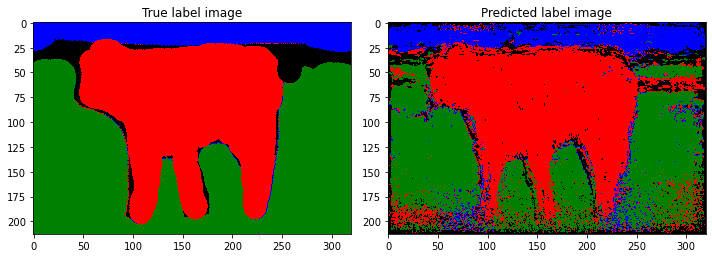

In [17]:
do_pred_forest(test_images[0], test_segmentations[0])

========== testing tree-0 ==========
========== testing tree-1 ==========
========== testing tree-2 ==========
========== testing tree-3 ==========
========== testing tree-4 ==========
all: (5, 213, 320, 4)
(213, 320)
True labels histogram:
Others (0) = 905 
Sheep (1) = 9173 
Water (2) = 0 
Grass (3) = 58082


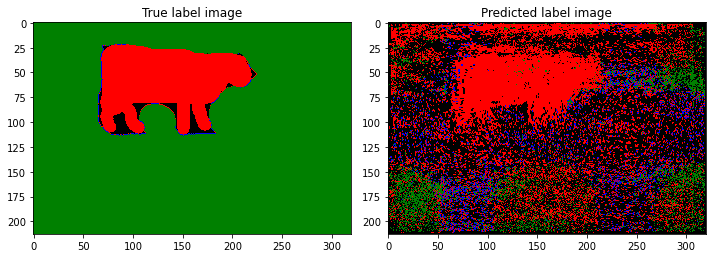

In [18]:
do_pred_forest(test_images[1], test_segmentations[1])

========== testing tree-0 ==========
========== testing tree-1 ==========
========== testing tree-2 ==========
========== testing tree-3 ==========
========== testing tree-4 ==========
all: (5, 213, 320, 4)
(213, 320)
True labels histogram:
Others (0) = 2024 
Sheep (1) = 13082 
Water (2) = 0 
Grass (3) = 53054


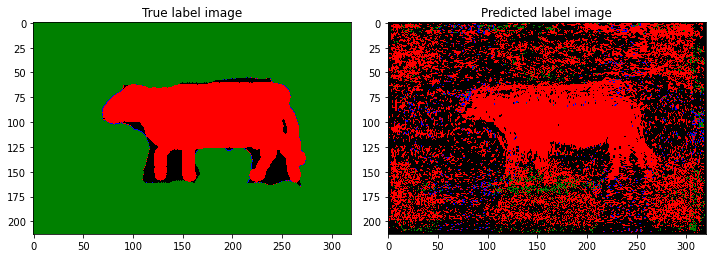

In [19]:
do_pred_forest(test_images[2], test_segmentations[2])

========== testing tree-0 ==========
========== testing tree-1 ==========
========== testing tree-2 ==========
========== testing tree-3 ==========
========== testing tree-4 ==========
all: (5, 213, 320, 4)
(213, 320)
True labels histogram:
Others (0) = 1215 
Sheep (1) = 19664 
Water (2) = 0 
Grass (3) = 47281


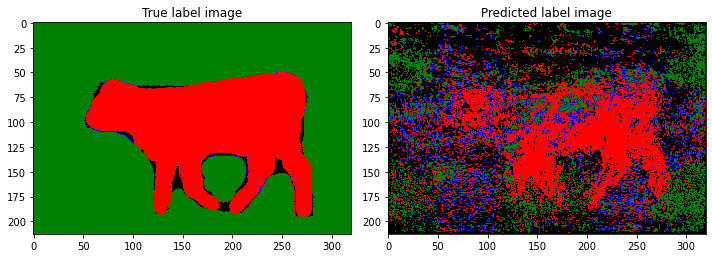

In [20]:
do_pred_forest(test_images[3], test_segmentations[3])